# Partial Dependence Plot
Individual Conditional Expectation (ICE)

Although the PDPs can give us some insight concerning the average model response, they can also hide some heterogeneous effects. This is because the PDPs show the average marginal effects. To visualize the response of each data point and uncover heterogeneous effects we can use the ICE plots.

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from alibi.explainers import PartialDependence, plot_pd

In [2]:
df = pd.read_csv('filtered_2.csv')
df.drop(['stop_sequence', 'route_id','Origin','Destination'], axis = 1, inplace = True)
df.head()

,0-3,3-6,6-9,9-12,12-15,15-18,18-21,21-24,monday,tuesday,wednesday,thursday,friday,saturday,sunday,delay
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0.0
1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,NaN
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.0
4,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0.0


In [3]:
df = df[df['delay'].notna()]

In [4]:
df.dtypes

0-3            int64
3-6            int64
6-9            int64
9-12           int64
12-15          int64
15-18          int64
18-21          int64
21-24          int64
monday         int64
tuesday        int64
wednesday      int64
thursday       int64
friday         int64
saturday       int64
sunday         int64
delay        float64
dtype: object

In [5]:
# extract feature names
feature_names = df.columns.tolist()
feature_names.remove('delay')

# define target names
target_names = ['delay']

# define categorical columns
categorical_columns_names = []

# define categorical and numerical indices for later preprocessing
categorical_columns_indices = [feature_names.index(cn) for cn in categorical_columns_names]
numerical_columns_indices = [feature_names.index(fn) for fn in feature_names if fn not in categorical_columns_names]

# extract data
X = df[feature_names]
y = df['delay']

# split data in train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
# define and fit the oridnal encoder
oe = OrdinalEncoder().fit(X_train[categorical_columns_names])

# transform the categorical columns to ordinal encoding
X_train.loc[:, categorical_columns_names] = oe.transform(X_train[categorical_columns_names])
X_test.loc[:, categorical_columns_names] = oe.transform(X_test[categorical_columns_names])

# convert data to numpy
X_train, y_train = X_train.to_numpy(), y_train.to_numpy()
X_test, y_test = X_test.to_numpy(), y_test.to_numpy()

# define categorical mappings
categorical_names = {i: list(v) for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [7]:
# define numerical standard sclaer
num_transf = StandardScaler()

# define categorical one-hot encoder
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in categorical_names.values()],
    handle_unknown='ignore',
)

# define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transf, categorical_columns_indices),
        ('num', num_transf, numerical_columns_indices),
    ],
    sparse_threshold=0
)

In [8]:
# fit preprocessor
preprocessor.fit(X_train)

# preprocess train and test datasets
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [9]:
# define and fit regressor - feel free to play with the hyperparameters
predictor = RandomForestRegressor(random_state=0)
predictor.fit(X_train_ohe, y_train)

# compute scores
print('Train score: %.2f' % (predictor.score(X_train_ohe, y_train)))
print('Test score: %.2f' % (predictor.score(X_test_ohe, y_test)))

Train score: 0.11
Test score: -0.06


In [10]:
prediction_fn = lambda x: predictor.predict(preprocessor.transform(x))

In [11]:
# define explainer
explainer = PartialDependence(predictor=prediction_fn,
                              feature_names=feature_names,
                              target_names=target_names,
                              categorical_names=categorical_names)

In [12]:
feature_names

['0-3',
 '3-6',
 '6-9',
 '9-12',
 '12-15',
 '15-18',
 '18-21',
 '21-24',
 'monday',
 'tuesday',
 'wednesday',
 'thursday',
 'friday',
 'saturday',
 'sunday']

In [13]:
# select features
features = [feature_names.index('0-3'),
            feature_names.index('3-6'),
            feature_names.index('6-9'),
            feature_names.index('9-12'),
            feature_names.index('12-15'),
            feature_names.index('15-18'),
            feature_names.index('18-21'),
            feature_names.index('21-24'),
            feature_names.index('monday'),
            feature_names.index('tuesday'),
            feature_names.index('wednesday'),
            feature_names.index('thursday'),
            feature_names.index('friday'),
            feature_names.index('saturday'),
            feature_names.index('sunday'),
            ]

In [14]:
# compute explanations
exp = explainer.explain(X=X_train,
                        features=features,
                        kind='both')

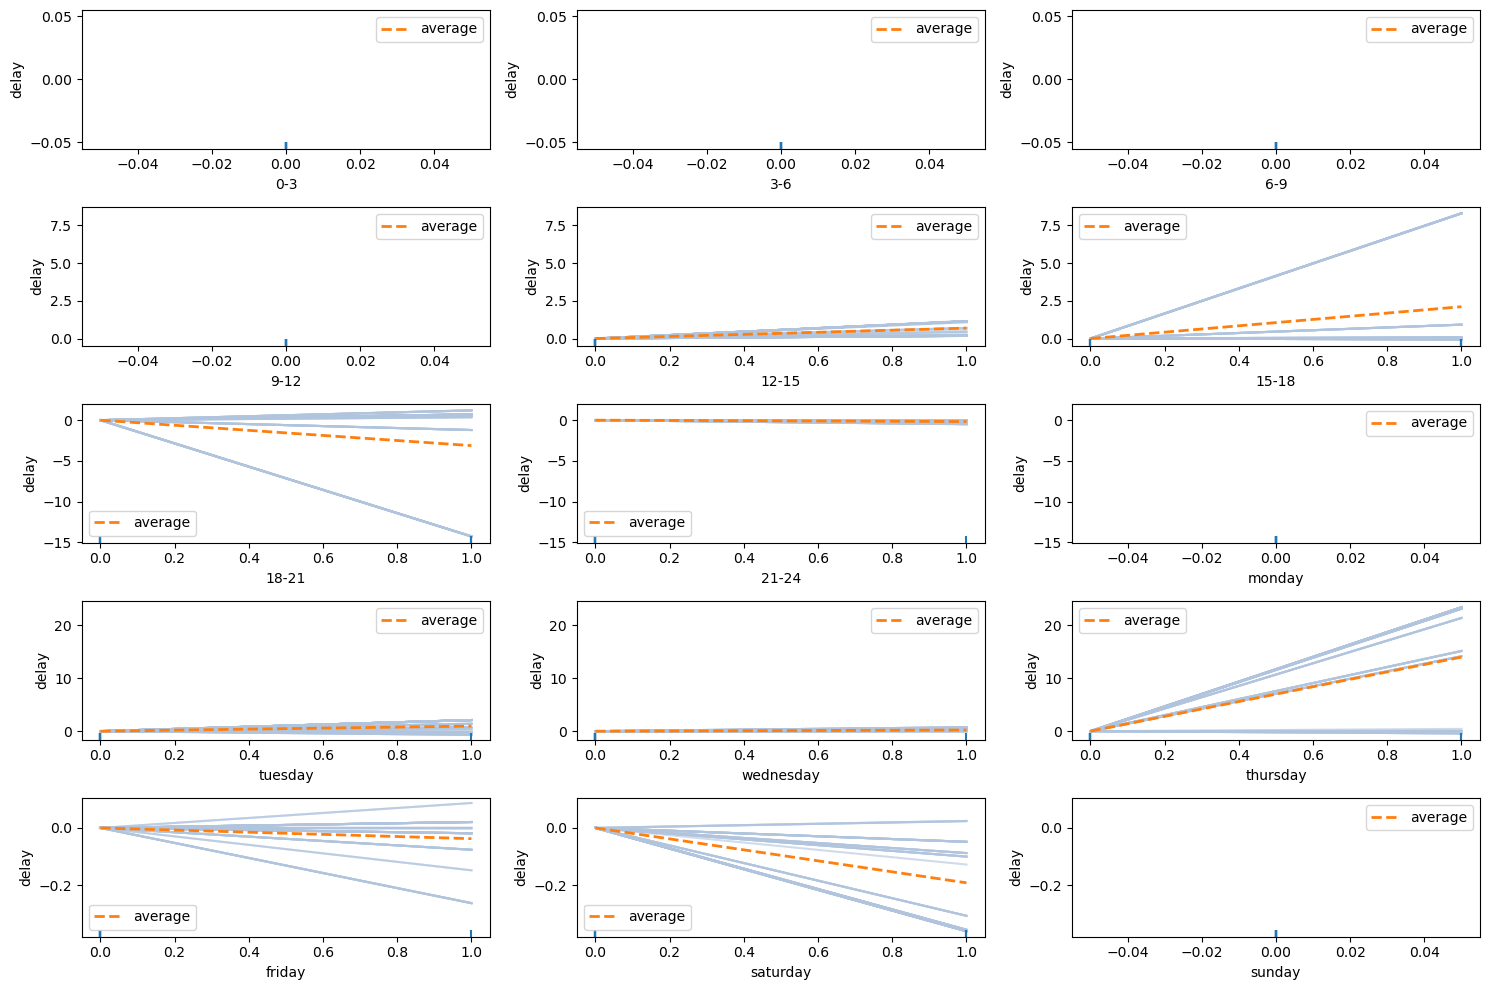

In [15]:
# random seed for `ice` sampling
np.random.seed(13)

# plot the pd and ice
plot_pd(exp=exp,
        n_cols=3,
        n_ice=50,   # number of ICE curves to be displayed. Can be set to 'all' or provided a list of indices
        sharey='row',
        center=True,  # center the plots for better visualization
        fig_kw={'figheight': 10, 'figwidth': 15});